In [1]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, AutoTokenizer
import torch

from lava import LavaModel
model = LavaModel.from_lava_pretrained('roberta-base', 'facebook/bart-base')

from utils.datasets_config import get_dataset

dset = get_dataset('gigaword', 'facebook/bart-base')
print(dset)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')




Some weights of BartForQuestionAnswering were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You passed along `num_labels=3` with an incompatible id to label map: {0: 'LABEL_0', 1: 'LABEL_1'}. The number of labels wil be overwritten to 2.
Found cached dataset gigaword (/home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-6816d5b30b6eeb9a.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-6aeaeef7bff602c5.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-29041409e3286f61.arrow


Number of gigaword training examples: 3803957
Number of gigaword validation examples: 189651
Number of gigaword testing examples: 1951
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 3803957
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 189651
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 1951
    })
})


In [2]:
training_args = TrainingArguments(
    # evaluation_strategy = "steps",
    output_dir= 'lava-ce',
    overwrite_output_dir=True,
    num_train_epochs=1,
    max_steps = 700_000,
    per_device_train_batch_size=4,
    save_steps=5_000,
    save_total_limit=20,
    prediction_loss_only=True,
    dataloader_num_workers=4,
    # learning_rate=3e-4,
    # logging_steps = 5,
    # eval_steps = 5,
    # metric_for_best_model = 'f1',
    # load_best_model_at_end=True,
)


In [3]:
def collate(batch):
    batch = ({k: torch.nn.utils.rnn.pad_sequence([dic[k] for dic in batch], batch_first=True, padding_value=1) for k in batch[0]})
    batch['input_ids'][batch['input_ids'] == 2] = 0
    batch['attention_mask'] = (batch['input_ids'] != 1).long()
    batch['labels'][batch['labels']==1] = -100
#     batch['labels'] = torch.nn.functional.pad(batch['labels'], (0, batch['input_ids'].shape[1] - batch['labels'].shape[1], 0, 0), 'constant', 1)
    return batch

In [4]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dset['train'].shuffle(1234),
    eval_dataset = dset['test'].shard(30, 1),
    data_collator = collate,
    # compute_metrics = lambda x: print(x),
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=7)],
)


Loading cached shuffled indices for dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-aac49639e82619d5.arrow
max_steps is given, it will override any value given in num_train_epochs


In [5]:
trainer._load_from_checkpoint('lava-ce/checkpoint-700000')

Loading model from lava-ce/checkpoint-700000.


In [6]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `LavaModel.forward` and have been ignored: label_texts, input_texts. If label_texts, input_texts are not expected by `LavaModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 65
  Batch size = 8


{'eval_loss': 1.0386759042739868,
 'eval_runtime': 1.1646,
 'eval_samples_per_second': 55.814,
 'eval_steps_per_second': 7.728}

In [17]:
d = next(iter(dset['test'].shard(300, 1).shuffle()))
decoder_input_ids = (d['labels'] == 1).long()

In [18]:
o = model(
    input_ids = d['input_ids'].cuda().unsqueeze(0),
    attention_mask = d['attention_mask'].cuda().unsqueeze(0),
)

In [19]:
d

{'input_ids': tensor([    0,   627,   579,  1069,   784,  3153,   260,   168,    15, 18862,
         46836,   585,     5,  6803,     9,   168,  1304,    19,  3169,  1683,
            25,    10,   831,   637,   136, 19665,   718, 21244, 18253,    11,
             5,  1926,     9,     5,   247,  1437,  1437,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([    0,    29,  1069,   784, 14391, 14454,  1304,    25,   997, 27196,
          1626,     2])}

In [20]:
o.logits.argmax(2)

tensor([[    0,   627,   579,  1069,   784,  3153,   260,   168,    15, 18862,
         46836,   585,     5,  6803,     9,   168,  1304,    19,  3169,  1683,
            25,    10,   831,   637,   136, 19665,   718, 21244, 18253,    11,
             5,  1926,     9,     5,   247,  1437,  1437,     0,     0,     0,
             0,     0,    11,     9,  1304,     2]], device='cuda:0')

In [21]:
tokenizer.decode(o.logits.argmax(2).tolist()[0], skip_special_tokens=False)


'<s>the sri lankan government on wednesday announced the closure of government schools with immediate effect as a military campaign against tamil separatists escalated in the north of the country  <s><s><s><s><s> in of schools</s>'

In [22]:
print(tokenizer.decode(d['input_ids'], skip_special_tokens=True))
print()
print(tokenizer.decode(d['labels'], skip_special_tokens=True))

the sri lankan government on wednesday announced the closure of government schools with immediate effect as a military campaign against tamil separatists escalated in the north of the country  

sri lanka closes schools as war escalates


In [23]:
scores = model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits
scores

tensor([[-6.2586, -6.2586, -6.2586, -6.2585, -4.2327, -3.7682, -2.1155, -0.3451,
          1.6599,  3.0890,  3.7387,  4.2100,  4.8997,  5.2446,  4.9608,  3.8474,
          3.6635,  3.7829,  3.5679,  3.1241,  2.4736,  1.6223,  0.8032,  0.1033,
         -0.3580, -0.6048, -0.6740, -0.5675, -0.3300, -0.0261,  0.3368,  0.7541,
          1.1923,  1.5889,  1.8936,  2.1313,  2.3525,  2.5722]],
       device='cuda:0', grad_fn=<CloneBackward0>)

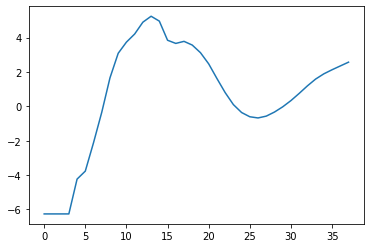

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 264,119,385 trainable parameters


In [26]:
model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits

tensor([[-6.2586, -6.2586, -6.2586, -6.2585, -4.2327, -3.7682, -2.1155, -0.3451,
          1.6599,  3.0890,  3.7387,  4.2100,  4.8997,  5.2446,  4.9608,  3.8474,
          3.6635,  3.7829,  3.5679,  3.1241,  2.4736,  1.6223,  0.8032,  0.1033,
         -0.3580, -0.6048, -0.6740, -0.5675, -0.3300, -0.0261,  0.3368,  0.7541,
          1.1923,  1.5889,  1.8936,  2.1313,  2.3525,  2.5722]],
       device='cuda:0', grad_fn=<CloneBackward0>)